# Classifying pulmonary diseases using chest X rays - pre trained model

<b>Contact info</b>
<br>
<b>Name:</b> Mardja Bueno, Ph.D.
<br>
<b>email:</b> mardja.bueno@gmail.com
<br>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
 
import warnings
warnings.filterwarnings('ignore')

In [11]:
# folders paths
train_path = 'Chest X ray images/train/'

In [13]:
# use tensorflow for the data augmentation and preprocessing
# split data into 80% training and 20% validation
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 
                 )
 
train_generator = gen.flow_from_directory(
    directory = train_path, 
    subset="training",
    color_mode="rgb",
    target_size = (331,331), 
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)
 
validation_generator = gen.flow_from_directory(
    directory = train_path, 
    subset="validation",
    color_mode="rgb",
    target_size = (331,331),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 5061 images belonging to 4 classes.
Found 1265 images belonging to 4 classes.


In [4]:
# load the InceptionResNetV2 architecture
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

# freeze the layer = its internal state will not change during training and weights will not be updated when fitting
base_model.trainable=False
 
model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax') # for the 4 classes present
    ])

In [5]:
# categorical cross entropy = used as a loss function for multi-class classification problems
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [6]:
# get summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 9, 9, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [7]:
# set early stopping call back
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)


In [8]:
batch_size=32

# hyperparameters
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
 
# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    callbacks=[early])

Epoch 1/15
158/158 [==============================] - 2134s 13s/step - loss: 0.3965 - accuracy: 0.8505 - val_loss: 0.1641 - val_accuracy: 0.9351
Epoch 2/15
158/158 [==============================] - 1876s 12s/step - loss: 0.1834 - accuracy: 0.9417 - val_loss: 0.1642 - val_accuracy: 0.9519
Epoch 3/15
158/158 [==============================] - 1730s 11s/step - loss: 0.1261 - accuracy: 0.9565 - val_loss: 0.1229 - val_accuracy: 0.9615
Epoch 4/15
158/158 [==============================] - 1739s 11s/step - loss: 0.1000 - accuracy: 0.9658 - val_loss: 0.1066 - val_accuracy: 0.9655
Epoch 5/15
158/158 [==============================] - 1818s 12s/step - loss: 0.0707 - accuracy: 0.9743 - val_loss: 0.1190 - val_accuracy: 0.9655
Epoch 6/15
158/158 [==============================] - 1920s 12s/step - loss: 0.0651 - accuracy: 0.9763 - val_loss: 0.1336 - val_accuracy: 0.9615
Epoch 7/15
158/158 [==============================] - 1699s 11s/step - loss: 0.0659 - accuracy: 0.9777 - val_loss: 0.1540 - val_ac

In [14]:
# evaluate the model
model.evaluate(validation_generator,steps = STEP_SIZE_VALID)

39/39 [==============================] - 340s 9s/step - loss: 0.1059 - accuracy: 0.9615


[0.10590669512748718, 0.9615384340286255]

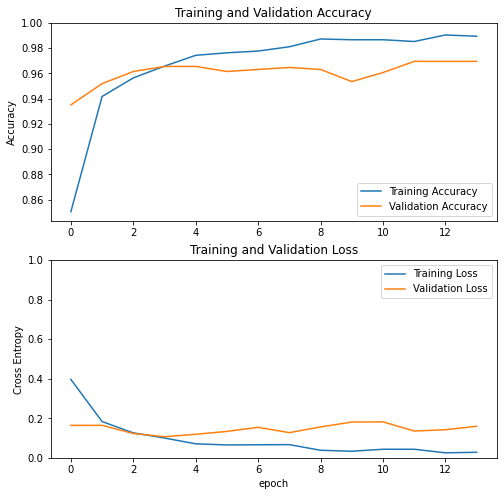

In [15]:
# plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
# save the model
model.save("ChestXrayModelPreTrained.h5")